In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:

plt.rcParams.update({
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'font.size': 14
})


| Method                 | Order | A-stable? | Symmetric? | Symplectic? | Algebraic stability? | Key Features |
|------------------------|-------|-----------|------------|-------------|-----------------------|--------------|
| Explicit Euler         | 1     | ❌ No      | ❌ No       | ❌ No        | ❌ No                 | Simplest explicit method |
| Classical RK4          | 4     | ❌ No      | ❌ No       | ❌ No        | ❌ No                 | High accuracy but not A-stable |
| Implicit Midpoint      | 2     | ✅ Yes     | ✅ Yes      | ✅ Yes       | ✅ Yes                | Good for stiff and Hamiltonian systems |
| 3-stage Gauss–Legendre | 6     | ✅ Yes     | ✅ Yes      | ✅ Yes       | ✅ Yes                | Implicit RK from Gauss–Legendre collocation; 3 stages achieve 6th order |


# 1st Order disspative sys
Imagine you have a cup of coffee cooling in a room. The temperature $T(t)$ of the coffee obeys Newton’s law of cooling:

$$\frac{dT}{dt} = -k(T - T_{\text{room}})$$

$T(t)$: temperature of the coffee at time $t$

$T_{\text{room}}$: room temperature (say 20°C)

$k$: cooling constant (say 0.1 per minute)

$h$: h minutes


In [2]:
def trueSolution(T: float = 90, Troom: float = 20, k: float = 0.1, h: float = 1):
    return Troom + (T - Troom) * np.exp(-k * h)


# 1. Explicit Euler
- local error: $O(h^2)$
- global error: $O(h^1)$

In [8]:
def Euler4CoffeeCooling(T: float = 90, Troom: float = 20, k: float = 0.1, h: float = 1):
    return T - h * k * (T - Troom)

# 2. Classical RK4  
- local error: $O(h^5)$
- global error: $O(h^4)$
- Nature: Explicit, 4-stage.
- Use: Widely used for non-stiff ODEs because it balances accuracy and computational cost. 

- Butcher tableau: (gotten from Taylor's expansion)
    ```python
    0   |
    1/2 | 1/2
    1/2 | 0    1/2
    1   | 0    0    1
    ----+----------------
        | 1/6  1/3  1/3  1/6
    ```

In [3]:
def RK44CoffeeCooling(T: float = 90, Troom: float = 20, k: float = 0.1, h: float = 1):
    k1 = - k * (T - Troom)
    k2 = - k * (T + (h / 2) * k1 - Troom)
    k3 = - k * (T + (h / 2) * k2 - Troom)
    k4 = - k * (T + (h) * k3 - Troom)
    return T + (h / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

# 3. Implicit midpoint (Gauss–Legendre 1-stage)
- formula: $y_{n+1} = y_n + h \, f\!\left(t_n + \tfrac{h}{2}, \tfrac{y_n + y_{n+1}}{2}\right)$

In [4]:
def midpoint4CoffeeCooling(T: float = 90, Troom: float = 20, k: float = 0.1, h: float = 1):
    return (T * (1 - k * h / 2) + h * k * Troom) / (1 + k * h / 2)

# 4. 3-Stage Gauss–Legendre Runge–Kutta methods
Definition: A family of implicit Runge–Kutta methods constructed using Gaussian quadrature nodes (Legendre polynomial roots).  
Order: For 𝑠 stages, the method achieves order 2𝑠.  
Example: 2-stage Gauss–Legendre RK → 4th-order accuracy.  

Properties:  
Symplectic (preserve geometric structure in Hamiltonian systems).  
A-stable (good for stiff problems).  
Require solving nonlinear systems at each step (implicit).

In [5]:
def threeGL4CoffeeCooling(T: float = 90, Troom: float = 20, k: float = 0.1, h: float = 1):

    sqrt15 = np.sqrt(15.0)
    A = np.array([
        [5/36, 2/9 - sqrt15/15, 5/36 - sqrt15/30],
        [5/36 + sqrt15/24, 2/9, 5/36 - sqrt15/24],
        [5/36 + sqrt15/30, 2/9 + sqrt15/15, 5/36]
    ], dtype=float)  # based on the Butcher Tableau

    b = np.array([5/18, 4/9, 5/18])

    # our aim equation is time free, so we don't need c

    # based on the implicit method: Y = y_n + h * A * f (Y), with Y a vector of length 3 whose elements are the nodes between y_n and y_{n+1}
    # we have the solution of Y as follows:
    ones = np.ones(3)
    I = np.eye(3)
    M = h * A * k + I
    rhs = T * ones + h * k * A @ ones * Troom
    Y = np.linalg.solve(M, rhs)  # solve the function MY = rhs
    
    return T + h * np.dot(b, (-k) * (Y - Troom * ones))

In [31]:
T0 = 90
Troom = 20
k = 0.1
h = 1

In [32]:
# one step solution
print("Euler:", Euler4CoffeeCooling())
print("RK4:", RK44CoffeeCooling())
print("Implicit Midpoint:", midpoint4CoffeeCooling())
print("3-Stage Gauss–Legendre:", threeGL4CoffeeCooling())

print("True solution:", trueSolution())

Euler: 83.0
RK4: 83.338625
Implicit Midpoint: 83.33333333333333
3-Stage Gauss–Legendre: 83.33861926245432
True solution: 83.33861926251717


In [33]:
# 100 steps solutions
steps = 300

times = np.arange(steps + 1)
T_true = [T0]
T_euler = [T0]
T_rk4 = [T0]
T_mid = [T0]
T_gl = [T0]

for i in range(steps):
    T_true.append(trueSolution(T_true[-1], Troom, k, h))
    T_euler.append(Euler4CoffeeCooling(T_euler[-1], Troom, k, h))
    T_rk4.append(RK44CoffeeCooling(T_rk4[-1], Troom, k, h))
    T_mid.append(midpoint4CoffeeCooling(T_mid[-1], Troom, k, h))
    T_gl.append(threeGL4CoffeeCooling(T_gl[-1], Troom, k, h))


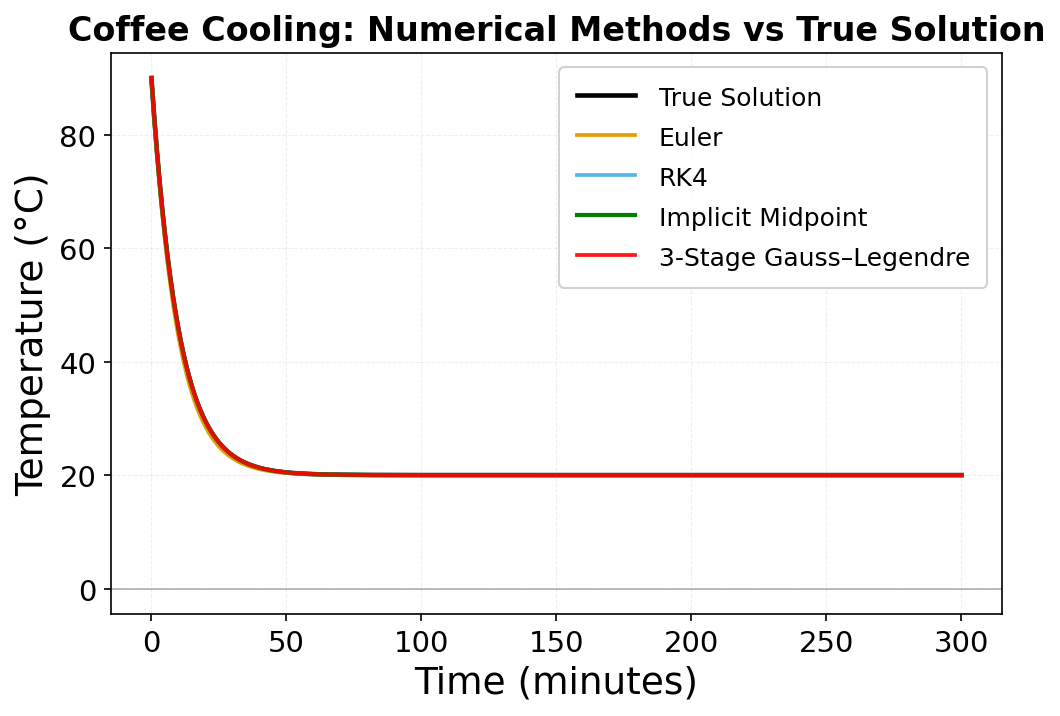

In [34]:
fig, ax = plt.subplots(figsize=(7, 5))

# A cohesive blue palette centered on 'royalblue'
colors = {
    
    'true': '#000000',   # black
    'euler': '#E69F00',  # orange
    'rk4':   '#56B4E9',  # sky blue
    'mid':   'green',  # bluish green
    'gl':   'red',  # vermillion

}

# ---- Plots (line styles mirror the “distinct but harmonious” approach) ----
ax.plot(times, T_true, label='True Solution', color=colors['true'], linewidth=2.2)
ax.plot(times, T_euler, label='Euler', color=colors['euler'], linewidth=1.8)
ax.plot(times, T_rk4, label='RK4', color=colors['rk4'], linewidth=1.8)
ax.plot(times, T_mid, label='Implicit Midpoint', color=colors['mid'], linewidth=2.0)
ax.plot(times, T_gl, label='3-Stage Gauss–Legendre', color=colors['gl'], linewidth=1.8, alpha=0.9)

# ---- Axes, labels, grid ----
ax.set_xlabel('Time (minutes)', fontsize=18)
ax.set_ylabel('Temperature (°C)', fontsize=18)
ax.set_title('Coffee Cooling: Numerical Methods vs True Solution', fontsize=16, fontweight='bold')

# Subtle dashed grid and neutral gray reference lines (consistent with the first figure)
ax.grid(True, alpha=0.2, linestyle='--', linewidth=0.5)
ax.axhline(0, color='gray', linewidth=0.8, alpha=0.6)   # optional, similar to the first plot
# ax.axvline(0, color='gray', linewidth=0.8, alpha=0.6) # enable if you want a y-axis line

# Legend styling
leg = ax.legend(frameon=True, fancybox=True, framealpha=0.9, borderpad=0.6, loc='best')
for text in leg.get_texts():
    text.set_fontsize(12)

plt.tight_layout()

# Save to file (optional)
# fig.savefig('coffee_cooling_timeseries.png', bbox_inches='tight')

plt.show()


In [28]:
T_end = 50

hs = [10, 5, 2.5, 1.25, 0.625, 0.3125, 0.15625, 0.078125]
errors_euler = []
errors_rk4 = []
errors_mid = []
errors_gl3 = []

for h in hs:
    steps = int(T_end / h)
    T_true = T0
    T_euler = T0
    T_rk4 = T0
    T_mid = T0
    T_gl3 = T0

    for _ in range(steps):
        T_true = trueSolution(T_true, Troom, k, h)
        T_euler = Euler4CoffeeCooling(T_euler, Troom, k, h)
        T_rk4 = RK44CoffeeCooling(T_rk4, Troom, k, h)
        T_mid = midpoint4CoffeeCooling(T_mid, Troom, k, h)
        T_gl3 = threeGL4CoffeeCooling(T_gl3, Troom, k, h)

    T_true_exact = trueSolution(T0, Troom, k, T_end)

    errors_euler.append(abs(T_euler - T_true_exact))
    errors_rk4.append(abs(T_rk4 - T_true_exact))
    errors_mid.append(abs(T_mid - T_true_exact))
    errors_gl3.append(abs(T_gl3 - T_true_exact))



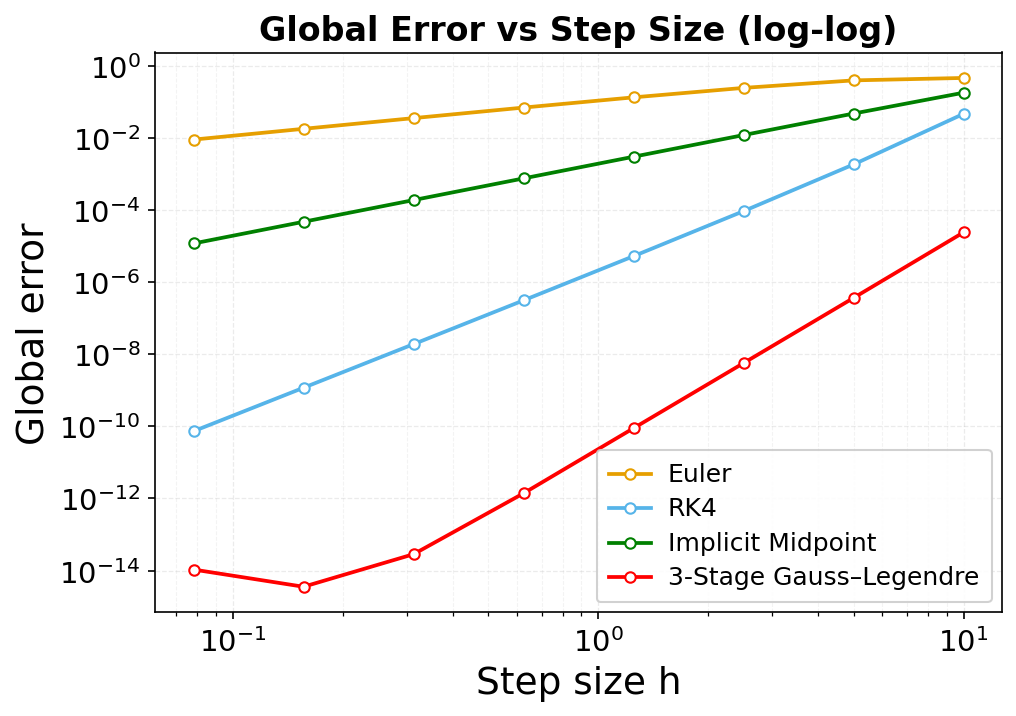

In [29]:
fig, ax = plt.subplots(figsize=(7, 5))

# 蓝色系调色，呼应前一幅图
colors = {
    'euler': '#E69F00',  # orange
    'rk4':   '#56B4E9',  # sky blue
    'mid':   'green',  # bluish green
    'gl3':   'red',  # vermillion
}

# 统一的线宽与标记样式（空心圆点，避免覆盖）
common = dict(marker='o', markersize=5, markerfacecolor='white', linewidth=1.8)

ax.loglog(hs, errors_euler, color=colors['euler'], label='Euler', **common)
ax.loglog(hs, errors_rk4,   color=colors['rk4'],   label='RK4', **common)
ax.loglog(hs, errors_mid,   color=colors['mid'],   label='Implicit Midpoint', **common)
ax.loglog(hs, errors_gl3,   color=colors['gl3'],   label='3-Stage Gauss–Legendre', **common)

# 轴标签与标题（与前文风格一致）
ax.set_xlabel('Step size h', fontsize=18)
ax.set_ylabel('Global error', fontsize=18)
ax.set_title('Global Error vs Step Size (log-log)', fontsize=16, fontweight='bold')

# 网格：对数坐标下同时开启主/次网格，样式与前图一致
ax.grid(True, which='major', alpha=0.25, linestyle='--', linewidth=0.6)
ax.grid(True, which='minor', alpha=0.15, linestyle='--', linewidth=0.5)

# 图例风格
leg = ax.legend(frameon=True, fancybox=True, framealpha=0.9, borderpad=0.6, loc='best', fontsize=10)
for text in leg.get_texts():
    text.set_fontsize(12)

plt.tight_layout()

# 可选保存
# fig.savefig('global_error_loglog.png', bbox_inches='tight')

plt.show()
